# Ensemble evaluation

In this notebook, our own model prediction performance is evaluated. This includes comparisons with GRACE, WaterGAP, and other reconstructions.

In [1]:
from typing import Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats
from statsmodels.tsa.seasonal import STL

import deepwaters  # noqa
from deepwaters import metrics
from deepwaters.preprocessing import calculate_grace_anomaly
from deepwaters.regions import basins
from deepwaters.utils import ROOT_DIR
from deepwaters.visualization import plot_basinwise_map

In [2]:
sns.set_style("whitegrid")
# plt.tight_layout() per default
mpl.rcParams["figure.autolayout"] = True
# Higher figure resolution
set_matplotlib_formats("retina")

# Register dask progress bar
ProgressBar(minimum=5).register()

Open model predictions:

In [3]:
STAGE: Literal["best", "latest"] = "best"
INPUT: Literal["nogap", "gap"] = "gap"

# Load and combine all test and train predictions
pred_dir = ROOT_DIR / "models/predictions/global"

folds = xr.open_zarr(pred_dir / f"ensemble_{INPUT}_huber.zarr")
# Use only best/latest predictions
stage_vars = [dvar for dvar in folds.data_vars if dvar.endswith(STAGE)]
folds = folds[stage_vars]
folds

FileNotFoundError: No such file or directory: 'C:\Users\luisg\Repositories\deepwaters\models\predictions\global\ensemble_gap_huber.zarr'

Get validation periods from Weights & Biases:

In [ ]:
dvar_names = list(folds.data_vars)
run_ids = [name.split("_")[1] for name in dvar_names]
run_ids

['ckwcwaph', 'e19hnivc', 'ig319zuo', 'jrcv2ke5', 'upaefmel']

In [ ]:
import wandb

api = wandb.Api()
project = "lgentner/deepwaters_global_ensemble"

folds_splits: dict[str, list[str]] = {}
folds_verbose: dict[str, str] = {}

for var_name in folds.data_vars:
    run_id = var_name.split("_")[1]
    run = api.run(f"{project}/{run_id}")
    config = run.config
    val_split = config["data"]["val_split"]
    fold_num = int(config["scenario"][-1])
    folds_splits[var_name] = val_split
    folds_verbose[var_name] = f"Fold {fold_num}"

In [ ]:
# Sort after value
folds_verbose = dict(sorted(folds_verbose.items(), key=lambda item: item[1]))
folds_splits = {var_name: folds_splits[var_name] for var_name in folds_verbose}

In [ ]:
for (name, split), fold in zip(folds_splits.items(), folds_verbose.values()):
    print(f"{name} ({fold}): {split}")

pred_e19hnivc_best (Fold 1): ['2002-04-01', '2005-09-01']
pred_ig319zuo_best (Fold 2): ['2005-10-01', '2008-10-01']
pred_ckwcwaph_best (Fold 3): ['2008-11-01', '2012-03-01']
pred_upaefmel_best (Fold 4): ['2012-06-01', '2017-06-01']
pred_jrcv2ke5_best (Fold 5): ['2018-06-01', '2021-12-01']


## Merge ensemble members


Calculate the mean:

In [ ]:
pred_mean = (
    folds.to_dataarray("fold")
    .mean("fold")
    .rename(f"pred_ensemble_{INPUT}_huber_{STAGE}")
)
# Calculate anomaly to GRACE baseline
pred_mean = calculate_grace_anomaly(pred_mean)

# Add to other folds
folds["ensemble_mean"] = pred_mean

folds_verbose["ensemble_mean"] = "Ensemble mean"

In [ ]:
WRITE = False
ZARR_STORE = pred_dir / "ensembles_combined.zarr"

if WRITE:
    pred_mean.to_dataset().to_zarr(ZARR_STORE, mode="a")

[########################################] | 100% Completed | 8.72 s
[########################################] | 100% Completed | 8.81 s
[########################################] | 100% Completed | 8.91 s
[########################################] | 100% Completed | 9.01 s


## Comparisons

Get target, WaterGAP and land mask:

In [ ]:
# Load data configuration
target_var = "twsa_csr"

target_var = 'twsa_csr'


In [ ]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)

In [ ]:
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
gap = inps.twsa_gap
true = tgts[target_var]

Merge everything:

In [ ]:
mgd = xr.merge([true, gap, folds, recs])
# Apply mask
mgd = mgd.where(mask == 1)
mgd

<xarray.Dataset> Size: 32GB
Dimensions:                 (time: 1480, lat: 360, lon: 720)
Coordinates:
  * lat                     (lat) float64 3kB -89.75 -89.25 ... 89.25 89.75
  * lon                     (lon) float64 6kB -179.8 -179.2 ... 179.2 179.8
  * time                    (time) datetime64[ns] 12kB 1901-01-01 ... 2024-04-01
Data variables: (12/21)
    twsa_csr                (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    twsa_gap                (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_3oj4kqm0_best      (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_7gc4cy97_best      (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ids63ek4_best      (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_qavn1gbe_best      (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    ...                      ...
    yin_csr_full            (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_csr_zerofill        (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_full           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_gsfc_zerofill       (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_full            (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill        (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
Attributes:
    long_name:      Terrestrial Water Storage Anomaly
    standard_name:  twsa
    units:          mm

Define more readable variable names:

In [ ]:
vars_verbose = {
    "twsa_csr": "CSR-M (ground truth)",
    "twsa_gap": "WaterGAP (WGHM)",
    "humphrey_gsfc_detrend": "Humphrey's GSFC REC (detrend)",
    "li_csr_full": "Li's CSR REC",
    "yin_csr_full": "Yin's CSR REC",
}
vars_verbose.update(folds_verbose)

In [ ]:
fold_vars = list(folds_verbose.keys())
eval_vars = list(vars_verbose.keys())
eval_vars.remove(target_var)

## Time series of folds
### Global

In [ ]:
# Calculate the required plot rows and columns
NCOLS = 3
nrows = int(np.ceil(len(fold_vars) / NCOLS))

subplot_kwargs = dict(
    nrows=nrows, ncols=NCOLS, sharex=True, sharey=True, figsize=(12, 6)
)
title_kwargs = dict(fontsize=16, weight="bold")

# Default Seaborn color palette, but without gray
cmap = [*sns.color_palette()]
cmap.pop(7);

In [ ]:
df_mean = (
    mgd[[*fold_vars, target_var]]
    .sel(time=slice("1940", None))
    .dw.weight_lat()
    .mean(["lat", "lon"])
    .to_pandas()
)
# Split GRACE timeseries in before/after GRACE-FO gap
# Interpolate the missing time steps within each series
grace_full = df_mean[target_var]
df_mean[target_var] = grace_full[:"2018-01-01"].interpolate(limit_area="inside")
df_mean[f"{target_var}_fo"] = grace_full.loc["2018-01-01":].interpolate(
    limit_area="inside"
)

# Perform LOESS decomposition
TREND_YRS = 3
period = 12
# trend usually is 150 % of seasonal
trend = 12 * TREND_YRS
seasonal = round(trend / 1.5)

df_trend = df_mean.copy()
for var in df_trend:
    series = df_mean[var].dropna()
    res = STL(series, period=period, seasonal=seasonal + 1, trend=trend + 1).fit()
    # Remove extrapolated start and end parts
    df_trend[var] = res.trend[(trend // 2) :][: -(trend // 2)]

# Combine GRACE and GRACE-FO series
df_trend[target_var] = df_trend[target_var].combine_first(df_trend[f"{target_var}_fo"])

[########################################] | 100% Completed | 13.20 s
[########################################] | 100% Completed | 13.29 s


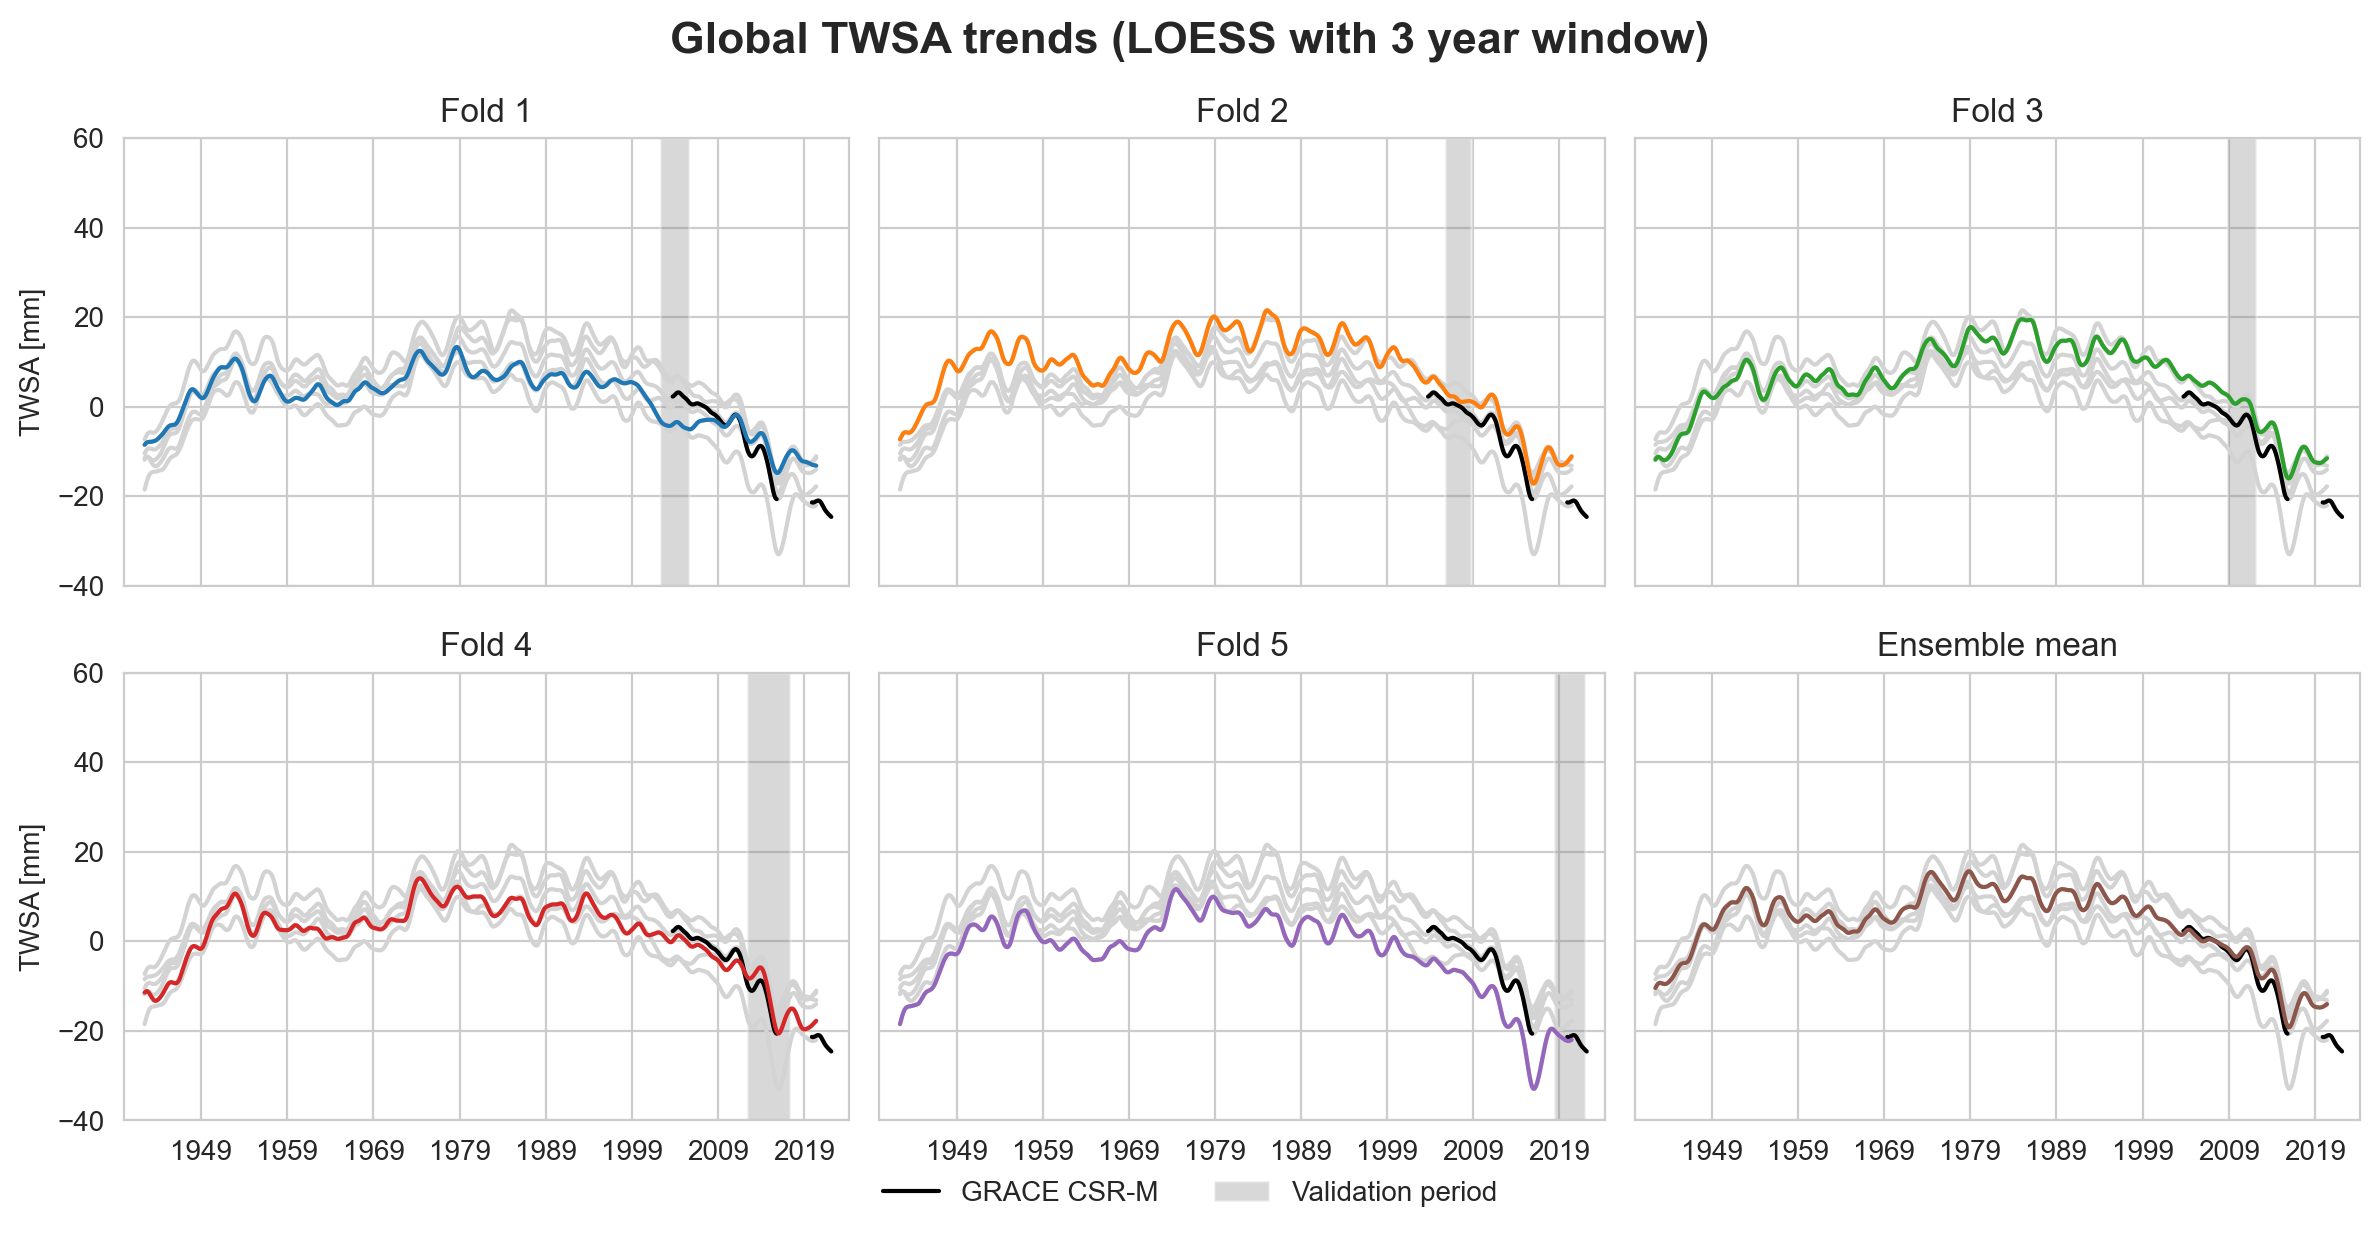

In [ ]:
fig, axs = plt.subplots(**subplot_kwargs)
# Create a second dataframe where columns start with an underscore
# so lines won't show up in legend
df_blank = df_trend.copy()
df_blank.columns = "_" + df_blank.columns
# Iterate over predictions/inputs
for i, (plot_var, ax) in enumerate(zip(fold_vars, axs.flat)):
    # Plot background
    df_blank.plot(ax=ax, color="lightgray", legend=False)
    # Plot target
    grace_label = "GRACE CSR-M" if i == 0 else "_"
    df_trend[target_var].plot(ax=ax, color="black", label=grace_label)
    # Plot prediction
    df_trend[plot_var].plot(ax=ax, color=cmap[i], label="_")
    # Plot val period
    if i < 5:
        start, end = folds_splits[plot_var]
        val_label = "Validation period" if i == 0 else "_"
        ax.axvspan(
            xmin=pd.Timestamp(start),
            xmax=pd.Timestamp(end),
            facecolor="gray",
            alpha=0.3,
            zorder=1,
            label=val_label,
        )
    ax.set(
        ylim=(-40, 30), xlabel=None, ylabel="TWSA [mm]", title=vars_verbose[plot_var]
    )

fig.suptitle(f"Global TWSA trends (LOESS with {TREND_YRS} year window)", **title_kwargs)
fig.legend(
    loc="lower center", bbox_to_anchor=(0.5, -0.03), title=None, ncols=2, frameon=False
);

## Amazon basin

[########################################] | 100% Completed | 17.55 s
[########################################] | 100% Completed | 17.62 s


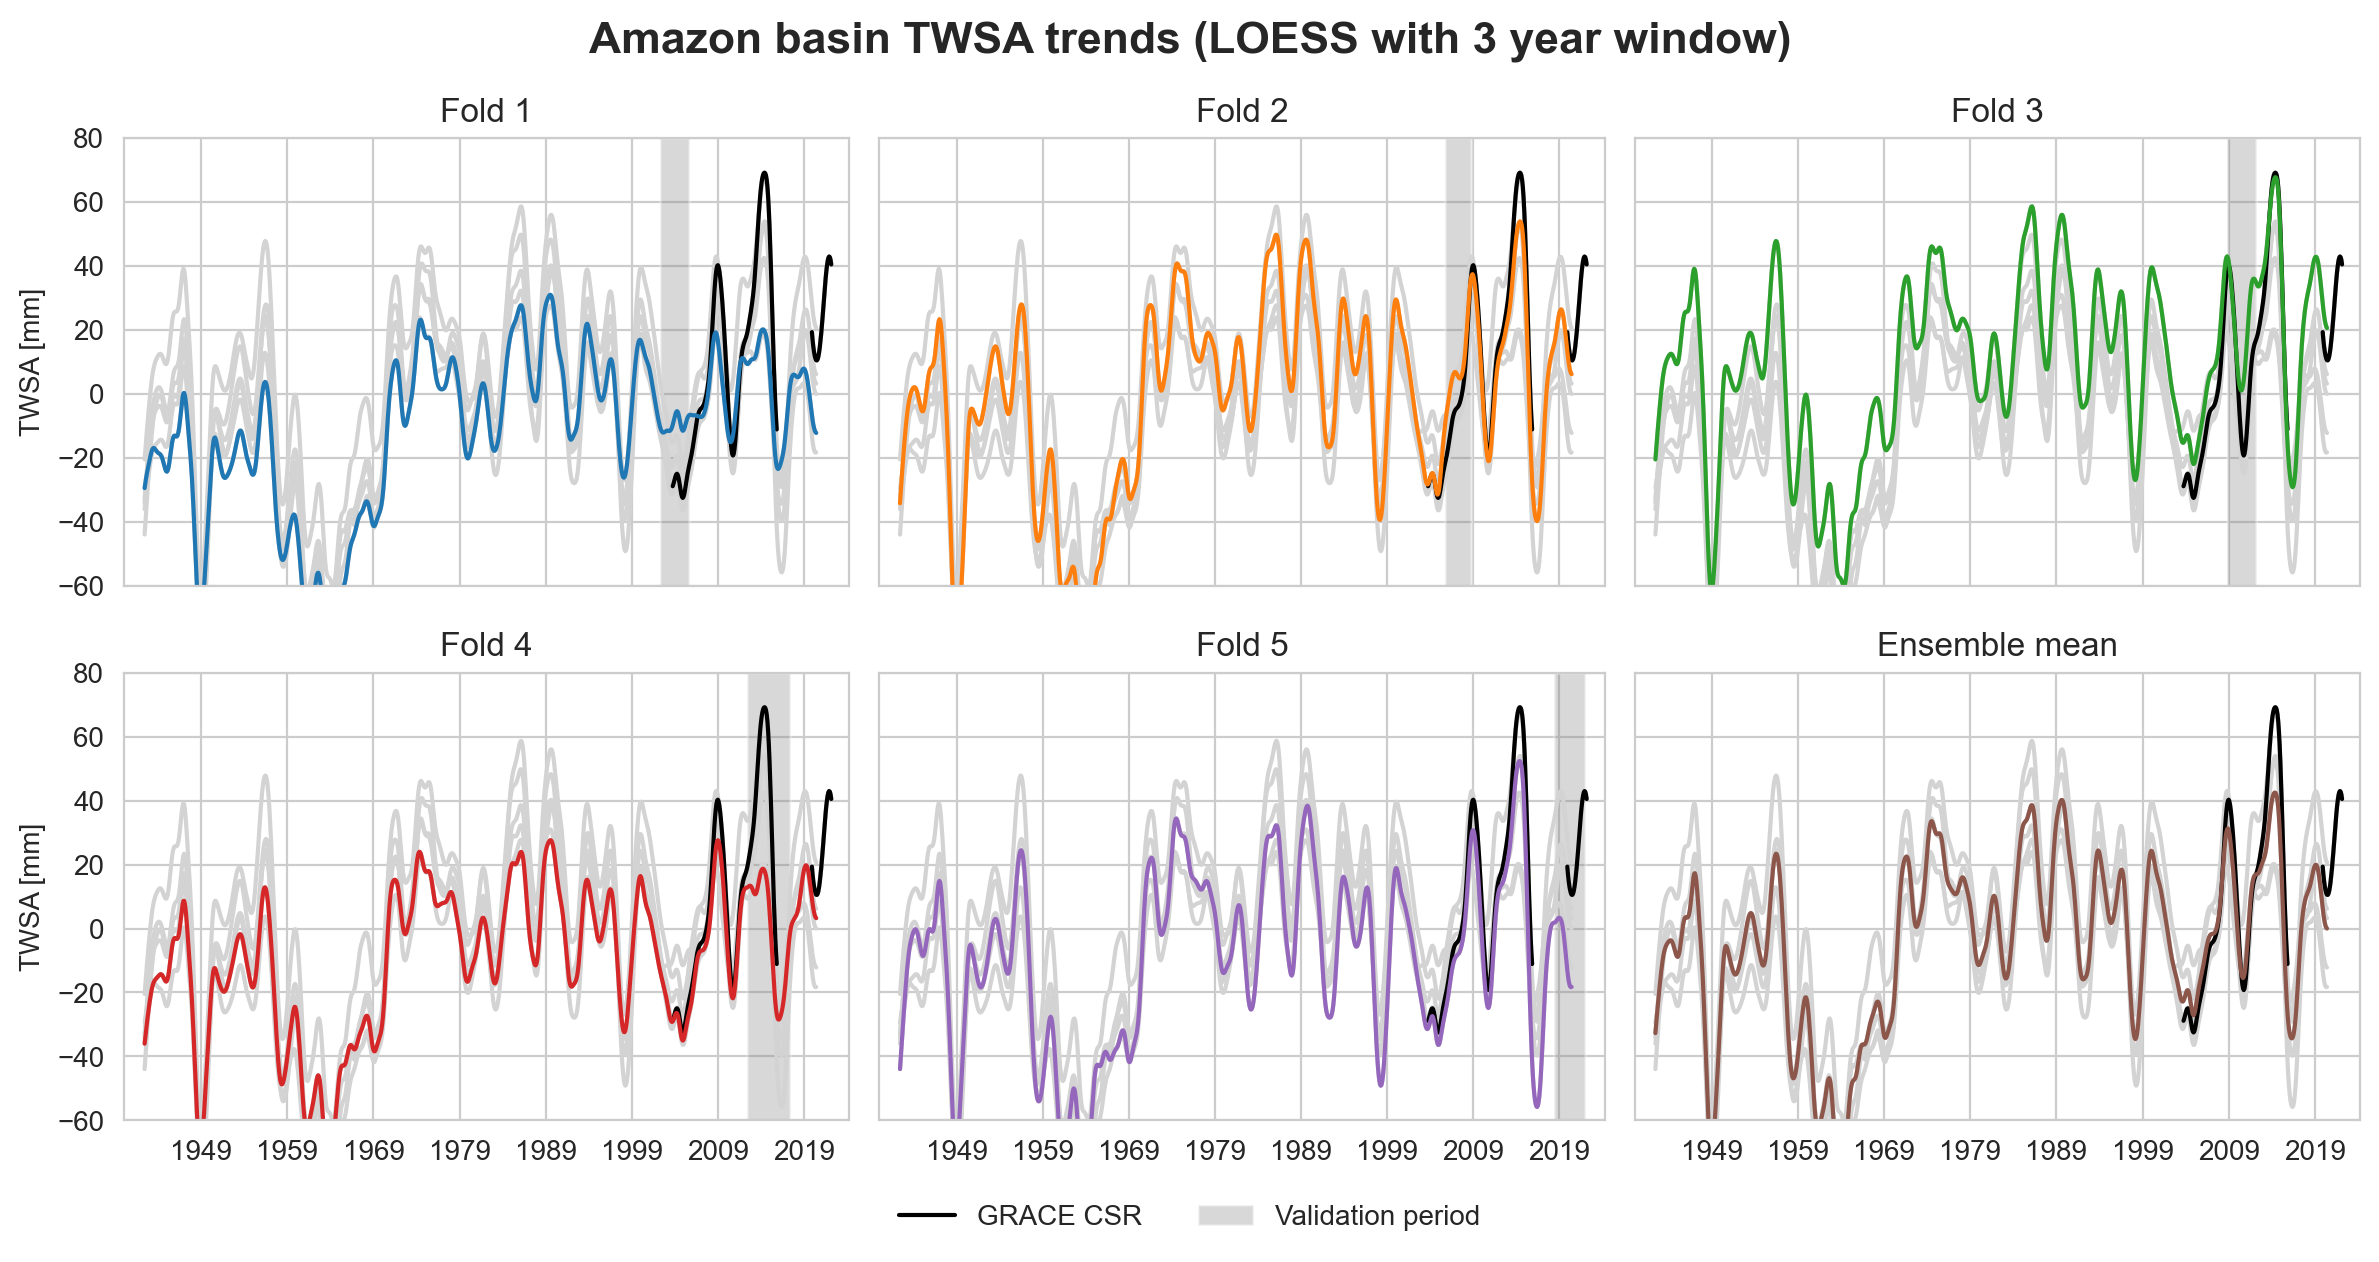

In [ ]:
# Create data frame from averaged time series
BASIN = "Amazon"
df_mean = (
    mgd[[*fold_vars, target_var]]
    .sel(time=slice("1940", None))
    .dw.select_basins(BASIN, return_region=False)
    .dw.weight_lat()
    .mean(["lat", "lon"])
    .to_pandas()
)

# Split GRACE timeseries in before/after GRACE-FO gap
# Interpolate the missing time steps within each series
grace_full = df_mean[target_var]
df_mean[target_var] = grace_full[:"2018-01-01"].interpolate(limit_area="inside")
df_mean[f"{target_var}_fo"] = grace_full.loc["2018-01-01":].interpolate(
    limit_area="inside"
)

df_trend = df_mean.copy()
for var in df_trend:
    series = df_mean[var].dropna()
    res = STL(series, period=period, seasonal=seasonal + 1, trend=trend + 1).fit()
    # Remove extrapolated start and end parts
    df_trend[var] = res.trend[(trend // 2) :][: -(trend // 2)]

# Combine GRACE and GRACE-FO series
df_trend[target_var] = df_trend[target_var].combine_first(df_trend[f"{target_var}_fo"])

# Create plot
fig, axs = plt.subplots(**subplot_kwargs)
# Create a second dataframe where columns start with an underscore
# so lines won't show up in legend
df_blank = df_trend.copy()
df_blank.columns = "_" + df_blank.columns
# Iterate over predictions/inputs
for i, (plot_var, ax) in enumerate(zip(fold_vars, axs.flat)):
    # Plot background
    df_blank.plot(ax=ax, color="lightgray", legend=False)
    # Plot target
    if i == 0:
        df_trend[target_var].plot(ax=ax, color="black", label="GRACE CSR")
    else:
        df_trend[target_var].plot(ax=ax, color="black", label="_")
    # Plot prediction
    df_trend[plot_var].plot(ax=ax, color=cmap[i], label="_")
    # Plot val period
    if i < 5:
        start, end = folds_splits[plot_var]
        val_label = "Validation period" if i == 0 else "_"
        ax.axvspan(
            xmin=pd.Timestamp(start),
            xmax=pd.Timestamp(end),
            facecolor="gray",
            alpha=0.3,
            zorder=1,
            label=val_label,
        )
    ax.set(
        ylim=(-80, 80), xlabel=None, ylabel="TWSA [mm]", title=vars_verbose[plot_var]
    )

fig.suptitle(
    f"{BASIN} basin TWSA trends (LOESS with {TREND_YRS} year window)", **title_kwargs
)
fig.legend(
    loc="lower center", bbox_to_anchor=(0.5, -0.05), title=None, ncols=2, frameon=False
);

## Score / correlation world maps
### Pixel-wise RMSE

In [ ]:
# Drop time steps where one of the variables is not available
mgd_nona = mgd[[*eval_vars, target_var]].where(mgd.dw.time_notnull(), drop=True)
preds_rmse = metrics.rmse(
    mgd_nona[target_var], mgd_nona[eval_vars], dim="time"
).compute()
da_rmse = preds_rmse.to_dataarray("model", name="rmse")
da_rmse.attrs["standard_name"] = "RMSE"
da_rmse.attrs["unit"] = "mm"

[########################################] | 100% Completed | 58.27 s
[########################################] | 100% Completed | 58.29 s
[########################################] | 100% Completed | 36.28 s
[########################################] | 100% Completed | 36.27 s


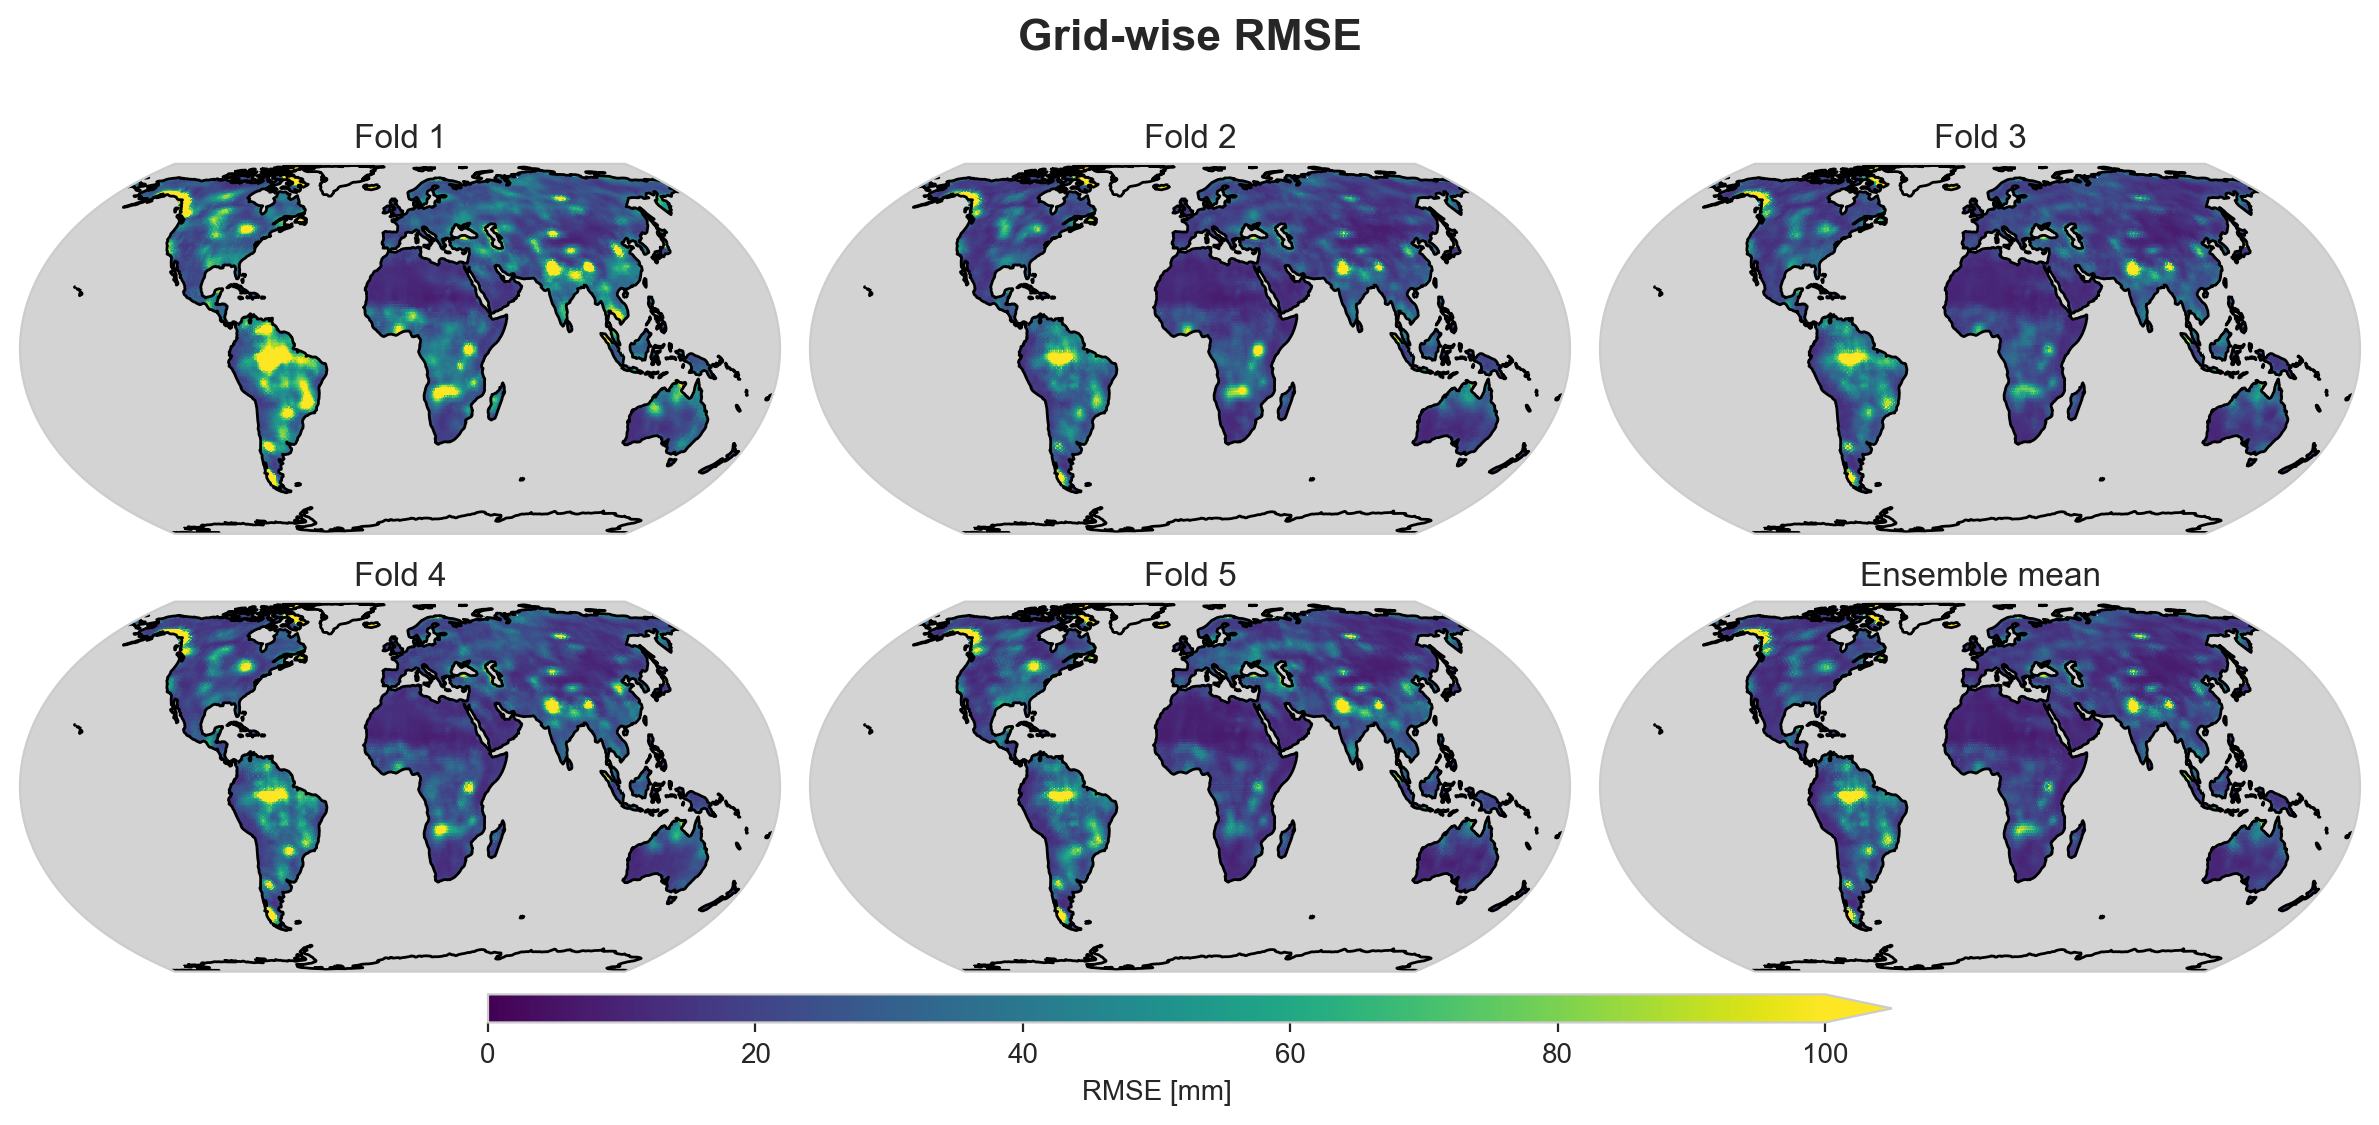

In [ ]:
plot_kwargs = dict(
    vmin=0,
    vmax=100,
    col_wrap=3,
    coastlines=True,
    cmap="viridis",
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.6, pad=0.02),
    figsize=(12, 6),
)
title_kwargs = dict(fontsize=16, weight="bold")

p = da_rmse.sel(model=fold_vars).dw.projplot(col="model", **plot_kwargs)

for ax, model in zip(p.axs.flat, fold_vars):
    ax.set_title(vars_verbose[model])
    ax.set_facecolor("lightgray")
p.fig.suptitle("Grid-wise RMSE", **title_kwargs);

### Basin-wise RMSE

Calculate the basin average time series:

In [ ]:
# Dims: ("model", "region")
basin_avg = (
    # Basins over 200,000 km²
    mgd_nona.dw.select_basins(top=72).dw.weight_lat().mean(["lat", "lon"])
).compute()

[########################################] | 100% Completed | 134.66 s
[########################################] | 100% Completed | 134.75 s


In [ ]:
preds_basin_rmse = metrics.rmse(basin_avg[target_var], basin_avg[eval_vars], dim="time")
da_basin_rmse = preds_basin_rmse.to_dataarray("model", name="rmse")
da_basin_rmse.attrs["standard_name"] = "RMSE"
da_basin_rmse.attrs["unit"] = "mm"

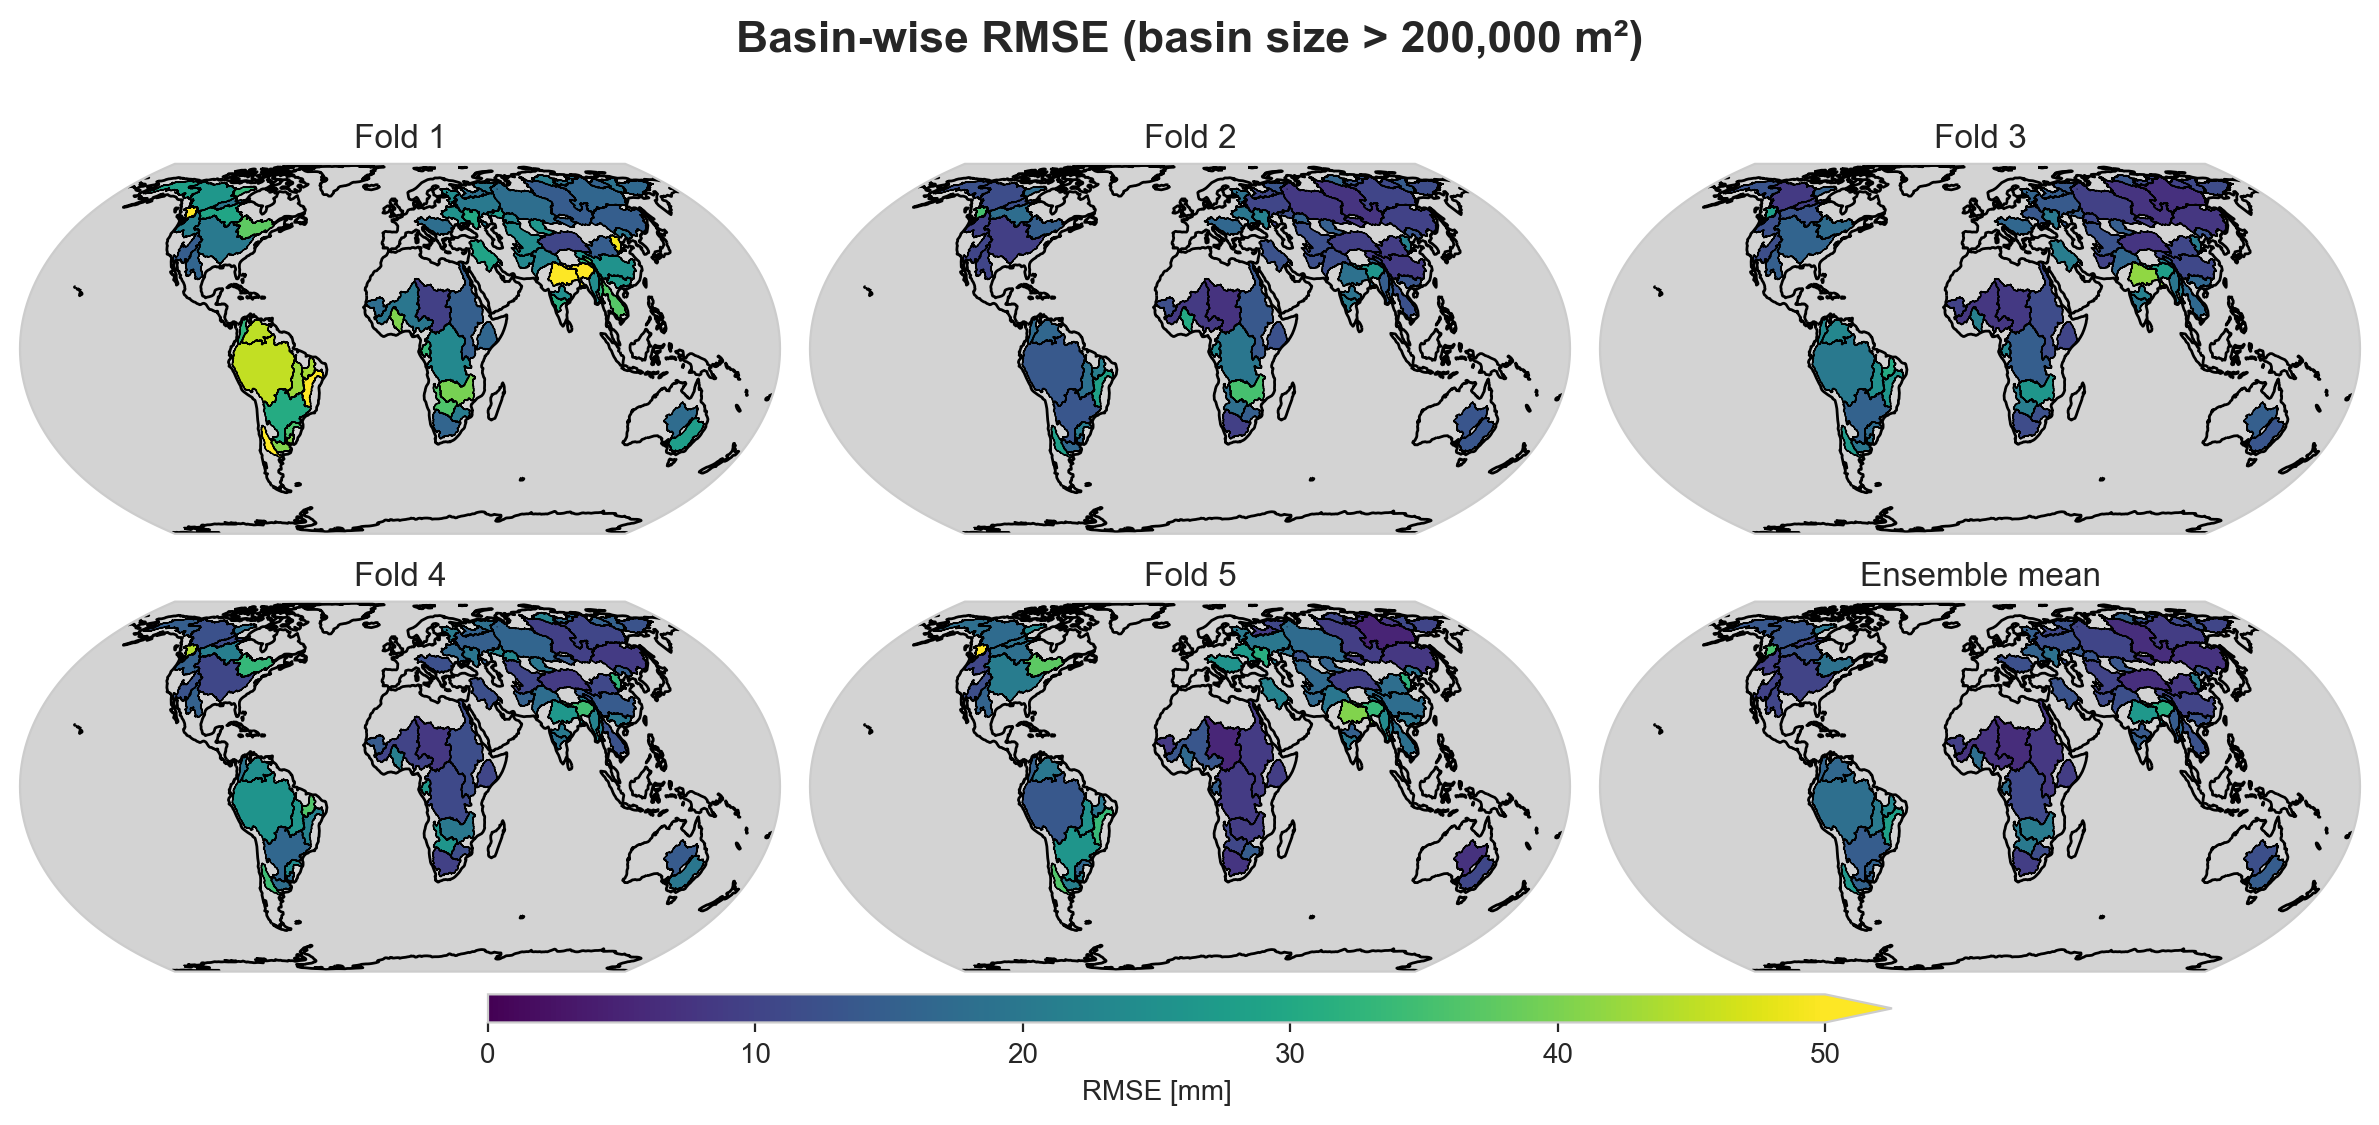

In [ ]:
plot_kwargs["vmax"] = 50

p = plot_basinwise_map(
    da_basin_rmse.sel(model=fold_vars),
    da_rmse.sel(model=fold_vars),
    col="model",
    **plot_kwargs,
)

basin_shapes = basins(top=72)
for ax, model in zip(p.axs.flat, fold_vars):
    ax.set_title(vars_verbose[model])
    basin_shapes.dw.projplot(ax=ax, edgecolor="black", linewidth=0.5, facecolor="None")
    ax.set_facecolor("lightgray")
p.fig.suptitle("Basin-wise RMSE (basin size > 200,000 m²)", **title_kwargs);

## Averaged RMSE

Calculate the averaged grid-wise RMSE:

In [ ]:
rmse_grid_avg = (
    da_rmse.dw.weight_lat().mean(["lat", "lon"]).rename("Grid-wise RMSE").compute()
)

Calculate the averaged basin-wise RMSE. We weigh each basin by the basin area:

In [ ]:
basin_areas = basin_shapes.set_index(basin_shapes.river.rename("region")).shape_area
area_weights = xr.DataArray.from_series(basin_areas)

In [ ]:
rmse_basin_avg = (
    da_basin_rmse.weighted(area_weights)
    .mean("region")
    .rename("Basin-wise RMSE")
    .compute()
)

In [ ]:
table = (
    xr.merge([rmse_basin_avg, rmse_grid_avg])
    .to_pandas()
    .rename(vars_verbose)
    .sort_values(by="Basin-wise RMSE")
)
table

,Basin-wise RMSE,Grid-wise RMSE
model,,
Ensemble mean,12.296588,26.519343
Fold 2,13.066345,29.085657
Fold 3,13.785088,28.621663
Yin's CSR REC,14.612985,24.820114
Fold 5,15.428162,28.945712
Fold 4,15.582161,32.157383
Li's CSR REC,16.681413,29.327407
Fold 1,24.755801,43.966240
Humphrey's GSFC REC (detrend),25.901261,53.097857


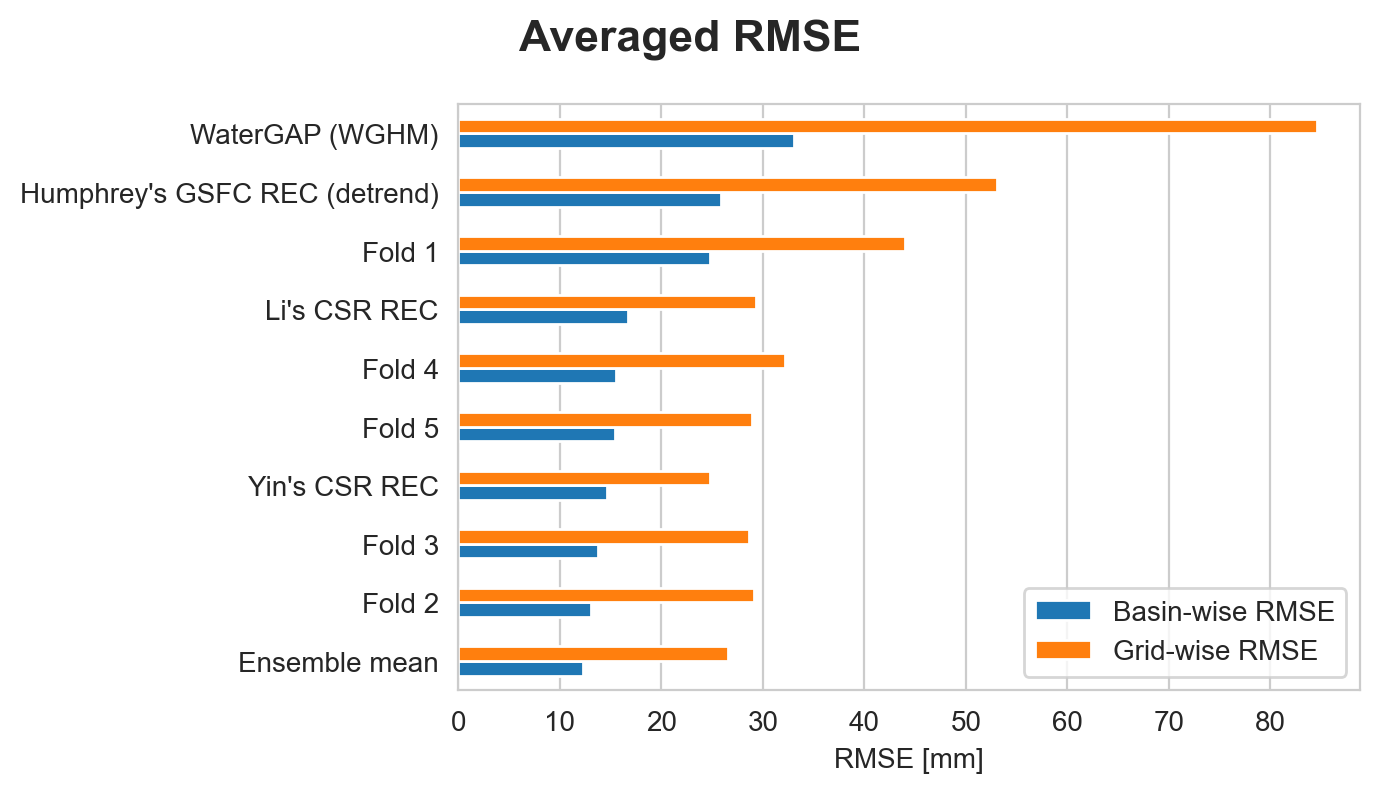

In [ ]:
ax = table.plot.barh(figsize=(7, 4))
ax.yaxis.grid(False)
ax.set_xlabel("RMSE [mm]")
ax.set_ylabel(None)
ax.figure.suptitle("Averaged RMSE", **title_kwargs)
ax.legend(loc="lower right");

## Partition RMSEs

Compare the RMSE of our models per partition (train, val, and test sets)

In [ ]:
partitions = ["train", "val", "test"]
series_list = []
for fold_name, val_split in folds_splits.items():
    # Get Dataset
    ds_part = mgd_nona.sel(time=slice(*val_split))
    # Calc RMSE over time per grid cell
    series = (
        metrics.rmse(ds_part[target_var], ds_part[eval_vars], dim="time")
        .to_dataarray("model", name="rmse")
        # Average over lat-lon
        .dw.weight_lat()
        .mean(["lat", "lon"])
        # Convert to series
        .to_pandas()
        .rename(f"Val {folds_verbose[fold_name]}")
    )
    series_list.append(series)

# Merge series into dataframe
df = pd.DataFrame(series_list).transpose()
df

[########################################] | 100% Completed | 35.57 s
[########################################] | 100% Completed | 35.66 s
[########################################] | 100% Completed | 33.42 s
[########################################] | 100% Completed | 33.52 s
[########################################] | 100% Completed | 35.72 s
[########################################] | 100% Completed | 35.82 s
[########################################] | 100% Completed | 32.20 s
[########################################] | 100% Completed | 32.18 s
[########################################] | 100% Completed | 21.16 s
[########################################] | 100% Completed | 21.18 s


,Val Fold 1,Val Fold 2,Val Fold 3,Val Fold 4,Val Fold 5
model,,,,,
twsa_gap,70.482184,63.379729,77.981163,97.597087,113.407366
humphrey_gsfc_detrend,41.741000,34.366181,45.236660,65.882578,80.751193
li_csr_full,26.506673,23.438215,26.065554,30.789858,45.758868
yin_csr_full,20.265781,14.518925,21.902941,28.181406,31.405876
pred_7gc4cy97_best,45.202822,33.501848,35.725294,48.470615,54.006976
pred_qrhrg8oa_best,22.194538,35.178745,22.187128,29.549723,31.188631
pred_qavn1gbe_best,21.394513,19.667431,36.710311,28.835747,29.811373
pred_ids63ek4_best,22.321175,20.224663,22.786215,48.585970,33.289439
pred_3oj4kqm0_best,21.899288,20.336988,22.572147,31.431075,55.447153


In [ ]:
df = df.drop(index="twsa_gap").rename(index=vars_verbose).reset_index()

In [ ]:
df_long = df.melt(
    id_vars="model",
    var_name="partition",
    value_name="rmse",
)
df_minmax = df_long.groupby("model").agg({"rmse": ["min", "max"]})

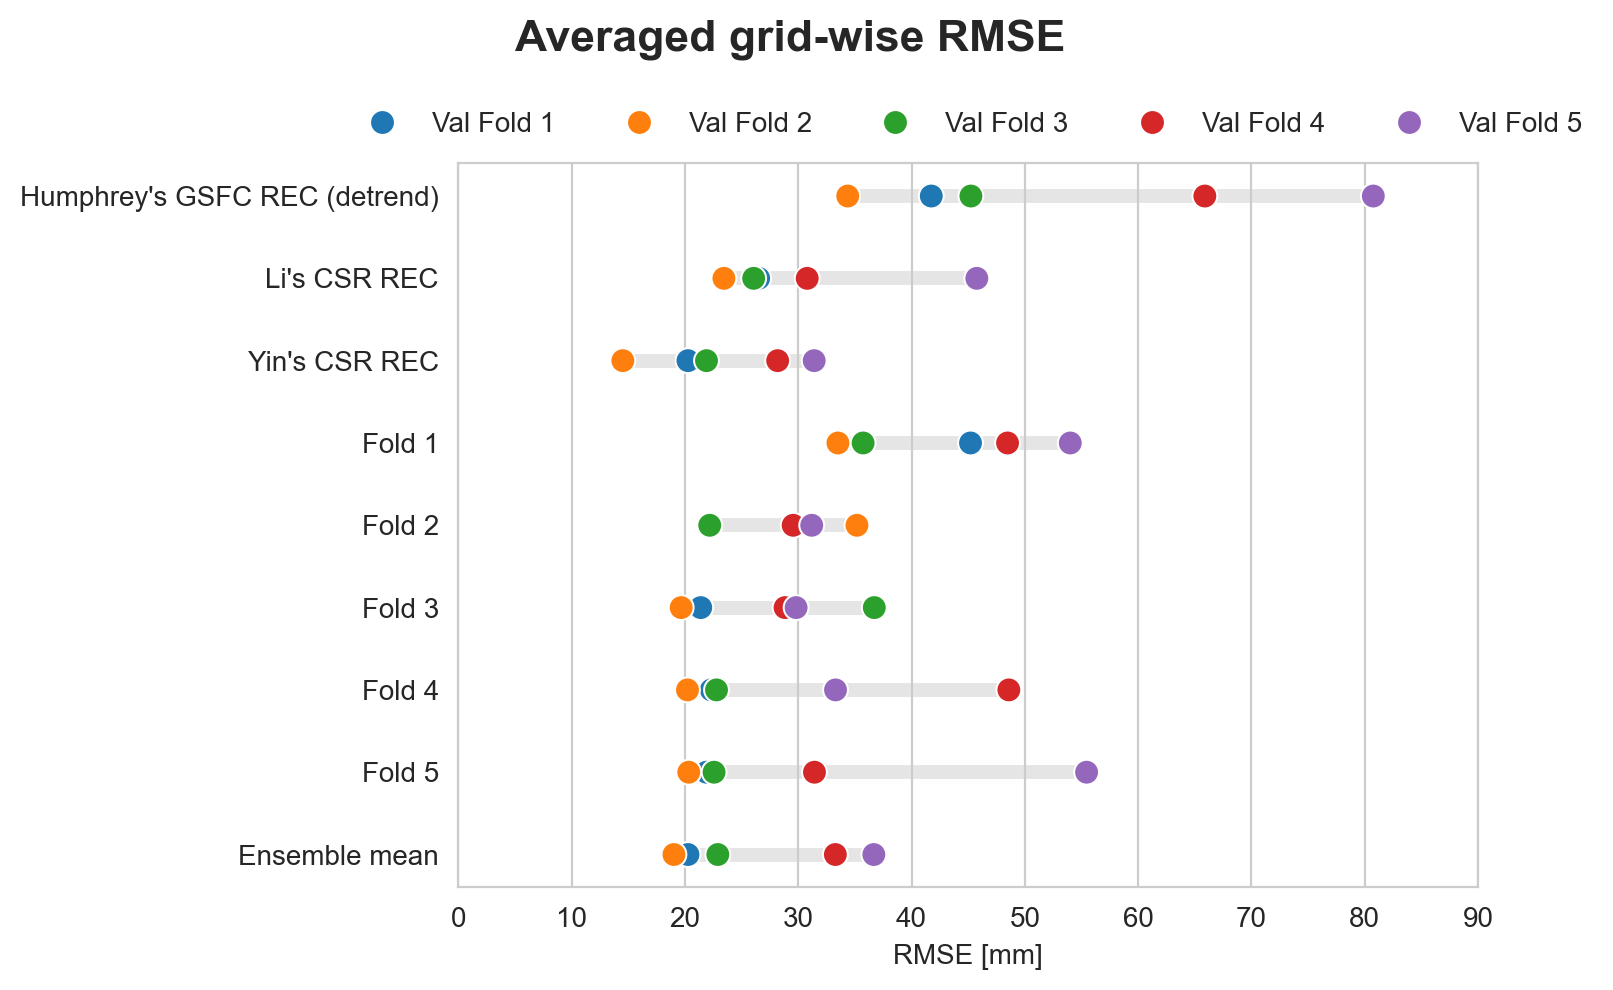

In [ ]:
scatter_kwargs = dict(s=80, edgecolors="white")
hlines_kwargs = dict(color="darkgray", lw=5, zorder=0, alpha=0.3)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(df_long, x="rmse", y="model", hue="partition", ax=ax, **scatter_kwargs)
ax.hlines(
    y=df_minmax.index,
    xmin=df_minmax.rmse["min"],
    xmax=df_minmax.rmse["max"],
    **hlines_kwargs,
)
ax.yaxis.grid(False)
ax.set_xlabel("RMSE [mm]")
ax.set_ylabel(None)
ax.set_xlim((0, 90))
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title=None, frameon=False
)
fig.suptitle(
    "Averaged grid-wise RMSE",
    fontsize=16,
    weight="bold",
);

### Basin wise

In [ ]:
# Basins over 200,000 km²
series_list = []
for fold_name, val_split in folds_splits.items():
    # Get Dataset
    basin_avg_part = basin_avg.sel(time=slice(*val_split))
    basin_rmse = metrics.rmse(
        basin_avg_part[target_var], basin_avg_part[eval_vars], dim="time"
    )

    series = (
        # Average over all basins
        basin_rmse.weighted(area_weights)
        .mean("region")
        .to_dataarray("model")
        # Convert to series
        .to_pandas()
        .rename(f"Val {folds_verbose[fold_name]}")
    )
    series_list.append(series)

# Merge series into dataframe
df = pd.DataFrame(series_list).transpose()
df

,Val Fold 1,Val Fold 2,Val Fold 3,Val Fold 4,Val Fold 5
model,,,,,
twsa_gap,26.910747,25.437394,30.519103,38.863101,46.434003
humphrey_gsfc_detrend,18.377168,15.315856,19.773051,33.377230,45.886541
li_csr_full,15.725389,12.743080,15.617976,15.956057,27.893679
yin_csr_full,11.693062,8.941498,14.108324,17.724965,19.172270
pred_7gc4cy97_best,27.204746,19.622983,20.760179,24.929775,28.951889
pred_qrhrg8oa_best,9.309387,18.935187,9.072927,11.170477,12.425947
pred_qavn1gbe_best,9.858772,9.256136,20.904418,11.402141,12.061431
pred_ids63ek4_best,10.281849,9.462662,10.159165,25.427319,12.514661
pred_3oj4kqm0_best,11.237261,11.068097,12.285177,15.203238,32.622287


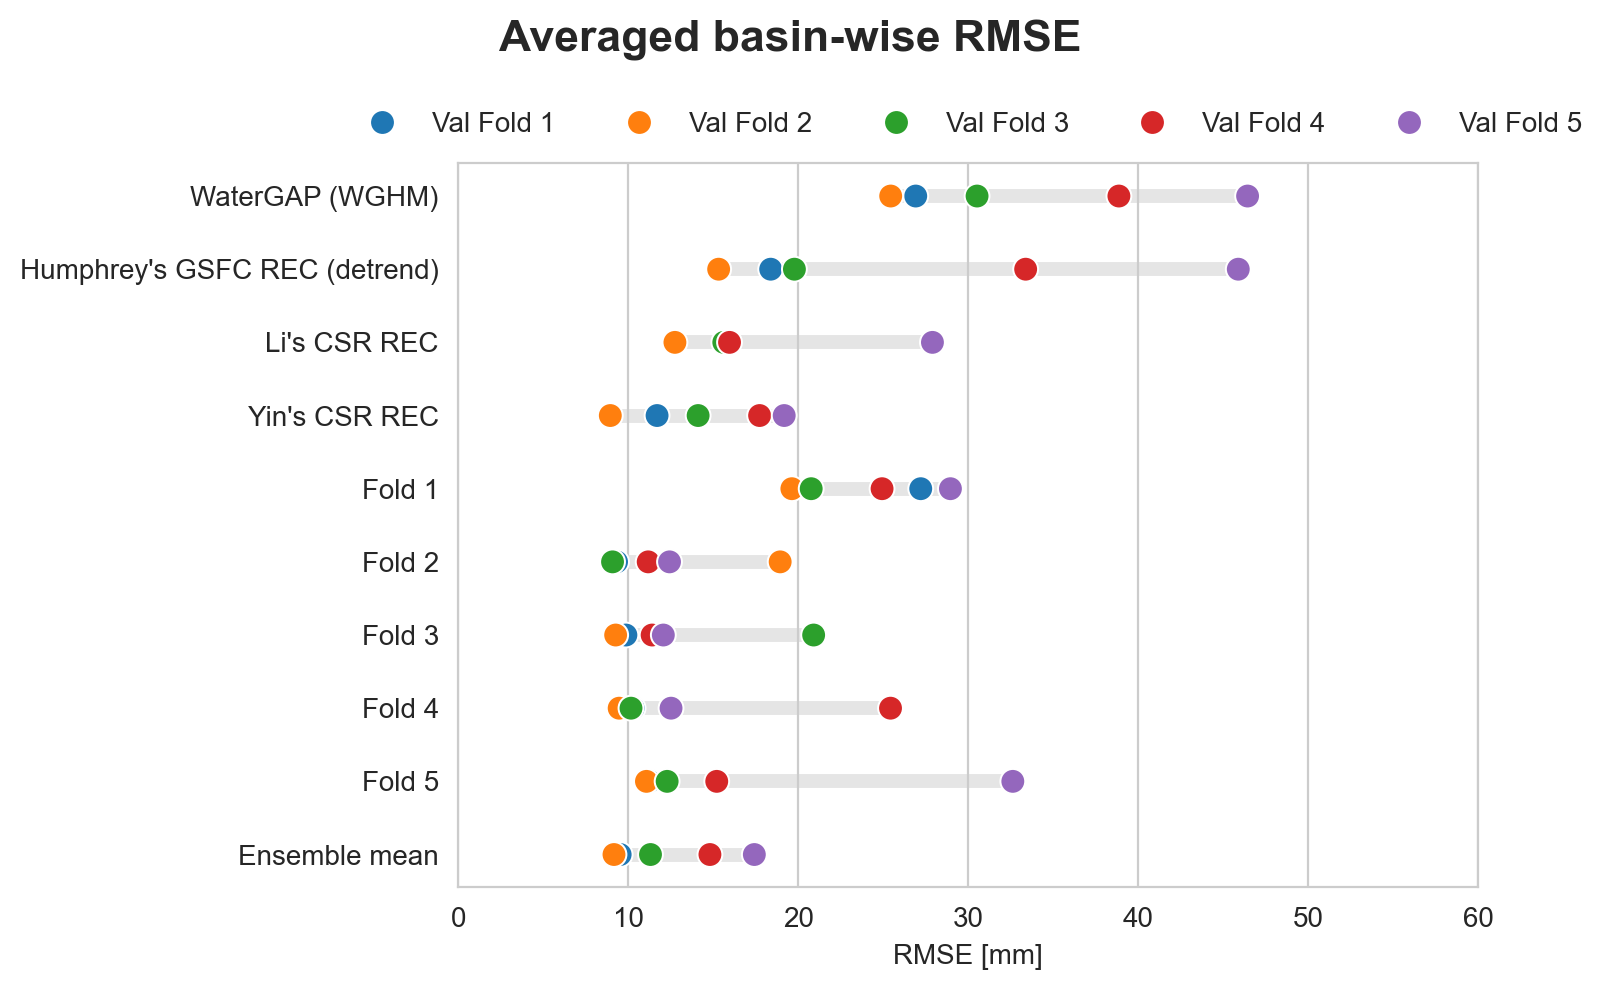

In [ ]:
df = df.rename(index=vars_verbose).reset_index()

df_long = df.melt(
    id_vars="model",
    var_name="partition",
    value_name="rmse",
)

df_minmax = df_long.groupby("model").agg({"rmse": ["min", "max"]})

fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(df_long, x="rmse", y="model", hue="partition", ax=ax, **scatter_kwargs)

ax.hlines(
    y=df_minmax.index,
    xmin=df_minmax.rmse["min"],
    xmax=df_minmax.rmse["max"],
    **hlines_kwargs,
)

ax.yaxis.grid(False)
ax.set_xlabel("RMSE [mm]")
ax.set_ylabel(None)
ax.set_xlim((0, 60))
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title=None, frameon=False
)
fig.suptitle(
    "Averaged basin-wise RMSE",
    fontsize=16,
    weight="bold",
);